# Dataset: Trackster neighborhood approach

Get tracksters from the cone neighbourhood.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - linked_inners: nodes linked to the given tracksters within its cone

Use the features from MLP approach per trackster.
Look at the graph of tracksters, extract information from the neighborhood and perform link prediction.
- convert the tracksters into some latent space and predict a link between them
- use edgeconv or sageconf to add information from the neighbourhood


In [1]:
import uproot
import torch
import random
import numpy as np
import awkward as ak

from reco.distance import euclidian_distance
from reco.dataset import TracksterGraph
from reco.matching import find_good_pairs
from reco.plotting import plot_tracksters, plot_graph_3D
from reco.graphs import create_graph
from reco.event import get_bary

import matplotlib.pyplot as plt


ds_name = "CloseByTwoPion"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

file_name = f"{raw_dir}/new_ntuples_15101852_191.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})
graph = uproot.open({file_name: "ticlNtuplizer/graph"})

Tracksters: 46
Simtracksters: 2
Candidate pairs: 223


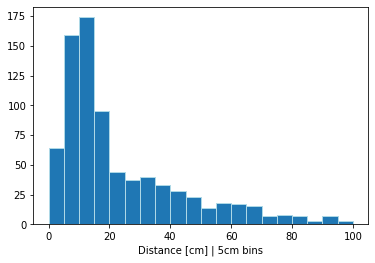

In [2]:
eid = 0

# prepare distance points
vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]
ve = tracksters["vertices_energy"].array()[eid]
vi = tracksters["vertices_indexes"].array()[eid]
clouds = [np.array([vx[tid], vy[tid], vz[tid]]).T for tid in range(len(vx))]

print("Tracksters:", len(vx))
print("Simtracksters:", len(simtracksters["stsSC_vertices_x"].array()[eid]))

MAX_DISTANCE = 10   # cm

candidate_pairs = []
distances = []

inners_list = graph["linked_inners"].array()[eid]
outers_list = graph["linked_outers"].array()[eid]

for i, inners in enumerate(inners_list):
    for inner in inners:
        dst = euclidian_distance(clouds[i], clouds[inner])
        distances.append(dst)
        if dst <= MAX_DISTANCE:
            candidate_pairs.append((i, inner))
            
print("Candidate pairs:", len(candidate_pairs))
c_pairs = set(candidate_pairs)

plt.hist(distances, bins=20, edgecolor="lightblue", range=(0, 100))
plt.xlabel("Distance [cm] | 5cm bins")
plt.show()

In [3]:
positive = find_good_pairs(tracksters, associations, c_pairs, eid)
negative = c_pairs - positive

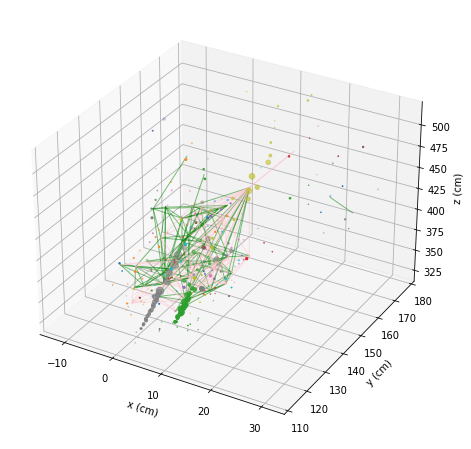

In [4]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111, projection='3d')

plot_tracksters(ax1, vx, vy, vz, ve)
bary = get_bary(tracksters, eid)

def plot_edge(ax, edge, color):
    a, b = edge
    ca = bary[a]
    cb = bary[b]
    x = (ca[0], cb[0])
    y = (ca[1], cb[1])
    z = (ca[2], cb[2])
    ax.plot(x, y, z, c=color, linewidth=1, alpha=0.5)

for edge in positive:
    plot_edge(ax1, edge, "green")

for edge in negative:
    plot_edge(ax1, edge, "pink")

plt.show()

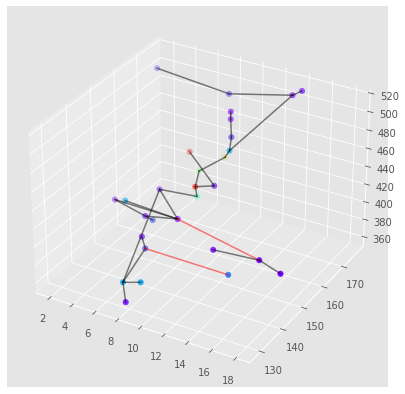

In [5]:
ca, cb = list(c_pairs)[2]

ca_lc = set(vi[ca])
cb_lc = set(vi[cb])

cvx = ak.flatten([vx[ca], vx[cb]])
cvy = ak.flatten([vy[ca], vy[cb]])
cvz = ak.flatten([vz[ca], vz[cb]])
cve = ak.flatten([ve[ca], ve[cb]])
cvi = ak.flatten([vi[ca], vi[cb]])

G = create_graph(cvx, cvy, cvz, cve, trk_lc_index=cvi, N=1, higher_e=True)

for edge in G.edges:
    a, b = edge
    ai = G.nodes[a]["index"]
    bi = G.nodes[b]["index"]
    if (ai in ca_lc and bi in cb_lc) or (bi in ca_lc and ai in cb_lc):
        G.edges[edge]["color"] = "green" if (ca, cb) in positive else "red"

plot_graph_3D(G, cve)

## Dataset

In [6]:
ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=1,
    MAX_DISTANCE=10,
    ENERGY_THRESHOLD=10,
    include_graph_features=False
)
ds

Processing...
/Users/ecuba/data/CloseByTwoPion/new_ntuples_15101852_157.root
Done!


TrackstersGraph(graphs=100, nodes=2960, edges=10971, max_distance=10, energy_threshold=10, graph_features=False)

Tracksters: 37 Edges: 202


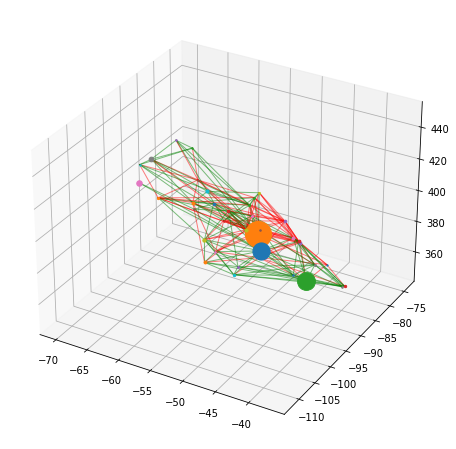

In [17]:
sample = ds[10]

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111, projection='3d')

nx = np.array(sample.x)
print("Tracksters:", nx.shape[0], "Edges:", len(sample.edge_index.T))

for tx in nx:
    ax1.scatter(tx[0], tx[1], tx[2], s=tx[3]*2)

def plot_edge(ax, nx, edge, color):
    a, b = edge

    x = (nx[a, 0], nx[b, 0])
    y = (nx[a, 1], nx[b, 1])
    z = (nx[a, 2], nx[b, 2])
    ax.plot(x, y, z, c=color, linewidth=1, alpha=0.5)

for edge, label in zip(sample.edge_index.T, sample.y):
    plot_edge(ax1, nx, edge, "green" if label == 1 else "red")

plt.show()